In [1]:
import gym
import math
import numpy as np
from scipy.special import hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import zeros, zeros_like
from numpy import ones, ones_like
from numpy import inf
from numpy import minimum, maximum
import matplotlib.pyplot as plt
import os
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3 import SAC
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

Main modifications:

-Introduced guess mode
When in guess mode the environment is reset to a random state. When in normal mode the environment is reset to the best state so far.

-Agent trapped
Introduced a control that terminates the episode if the agent has taken too many steps without improvement.

-Min reward capped
When the rewards get smaller than a big multiple of the best reward the episode is terminated. This should avoid divergencies in the loss. 

-Action and initial state scaled
The action is scaled so that it can take value in [-6.5, 6.5], the initial random state is scaled so that it can take value in [0,6.5]


In [2]:
def g(h,hb,z,zb):
    return (1/2 if h==hb else 1)*(z**h*zb**hb*hyp2f1(h,h,2*h,z)*hyp2f1(hb,hb,2*hb,zb)+zb**h*z**hb*hyp2f1(h,h,2*h,zb)*hyp2f1(hb,hb,2*hb,z))

def p(h,hb,c,z,zb):
    return c*(((z-1)*(zb-1))**(1/8)*g(h,hb,z,zb)-z**(1/8)*zb**(1/8)*g(h,hb,1-z,1-zb))

pts = rand(29,2)


def e(spec,pts):
    return [(sum([p(n[0],n[1],n[2],z[0],z[1]) for n in spec]) + ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts]

test_spec = array([[2.,2.,2.44e-4],[.5,.5,.25],[2.,0.,.016],[4.,0.,2.2e-4],[6.,0.,1.36e-5]])

spins = array([0,0,2,4,6])

class IsingEnv(gym.Env):
    def __init__(self, guess_mode_steps=0, trapped_steps=100, reward_cap=100, reward_scale=1.):
        self.action_space = gym.spaces.Box(array([-1 for i in range(10)]), array([1 for i in range(10)]))
        self.observation_space = gym.spaces.Box(array([-inf for i in range(29)]),array([inf for i in range(29)]))
        self.n = 5
        self.best_reward=None  #Records best reward
        self.best_state=None   #Records best state
        self.scale=reward_scale #Scale the error
        self.state = rand(10)*6.5 #Added in initialization
        self.guess_mode=True #Controls wheter the algorithm is working in guess mode
        self.guess_mode_steps=guess_mode_steps #Number of steps to take in guess mode
        self.step_counter=0 #Records the number of steps executed in the environment
        self.not_improving_steps=0 #Stores the number of steps since last improvement
        self.trapped_steps=trapped_steps #Maximum number of steps after which the environment is reset
        self.current_reward=None  #Current reward for guess mode
        self.improv_hist=[] #Records reward when a new best state is found
        self.reward_cap=reward_cap
    def step(self, action):
        current_obs=self._get_obs()
        current_reward=-norm(current_obs)*self.scale
        self.state=self.state+action*6.5 #scale the action so it can reach all points in one step
        self.state = maximum(zeros_like(self.state), self.state)
        self.state = minimum(6.5*ones_like(self.state), self.state)
        obs = self._get_obs()
        reward = -norm(obs)*self.scale
         
        if self.best_reward is None:
            self.best_reward=reward
            self.best_state=self.state

        self.step_counter+=1 #Increase step counter to control guess_mode

        if self.guess_mode:

            if self.step_counter>self.guess_mode_steps: #end guess_mode
                self.guess_mode=False
                done=True
            #check update best reward
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.improv_hist.append((self.step_counter, reward, self.state))
                self.not_improving_steps=0


            if reward>current_reward:
                done=True
            else:
                self.not_improving_steps+=1
                done=False

        else:
            #check update best reward and terminate
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.not_improving_steps=0
                self.improv_hist.append((self.step_counter, reward, self.state))
                done = True
            else:
                self.not_improving_steps+=1
                done = False
            if reward<self.reward_cap*self.best_reward: #This should limit instabilities and divergencies
                    done=True

        if self.not_improving_steps>self.trapped_steps:
                self.not_improving_steps=0
                done=True

        info = {}
        return obs, reward, done, info

    def reset(self):
        if self.guess_mode:
            self.state = rand(10)*6.5 #reset to a random state only in guessing mode
        else:
            self.state=self.best_state
        return self._get_obs()

    def _get_obs(self):
        spec = [[(self.state[2*i]+spins[i])/2, (self.state[2*i]-spins[i])/2, self.state[2*i+1]]for i in range(self.n)]
        return e(spec, pts)

In [3]:
guess_steps=2000
total_steps=11000
trapped=20 
reward_scale=0.005

env=IsingEnv(guess_mode_steps=guess_steps,trapped_steps=trapped, reward_scale=reward_scale)
log_dir = "tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
monitor=Monitor(env,log_dir)
model = SAC(MlpPolicy,monitor, verbose=1, learning_rate=5e-4, buffer_size=100000, learning_starts=1000, batch_size=64,
            tau=0.001, gamma= 0.99, device='cuda', ent_coef=200)
model.learn(total_timesteps=total_steps, log_interval=100)

C:\Users\Gabriele\.conda\envs\tf-gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.89     |
|    ep_rew_mean     | -1.7e+04 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 56       |
|    time_elapsed    | 3        |
|    total timesteps | 189      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.89     |
|    ep_rew_mean     | -2e+04   |
| time/              |          |
|    episodes        | 200      |
|    fps             | 57       |
|    time_elapsed    | 6        |
|    total timesteps | 378      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.76      |
|    ep_rew_mean     | -1.65e+04 |
| time/              |           |
|    episodes        | 300       |
|    fps             | 57        |
|    time_elapsed    | 

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.1       |
|    ep_rew_mean     | -1.08e+04 |
| time/              |           |
|    episodes        | 1800      |
|    fps             | 17        |
|    time_elapsed    | 193       |
|    total timesteps | 3320      |
| train/             |           |
|    actor_loss      | 2.96e+04  |
|    critic_loss     | 5.19e+08  |
|    ent_coef        | 200       |
|    learning_rate   | 0.0005    |
|    n_updates       | 2319      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.01      |
|    ep_rew_mean     | -3.56e+03 |
| time/              |           |
|    episodes        | 1900      |
|    fps             | 16        |
|    time_elapsed    | 201       |
|    total timesteps | 3421      |
| train/             |           |
|    actor_loss      | 2.87e+04  |
|    critic_loss     | 3.75e+08  |
|    ent_coef       

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.05     |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 3300     |
|    fps             | 14       |
|    time_elapsed    | 333      |
|    total timesteps | 4956     |
| train/             |          |
|    actor_loss      | 1.64e+04 |
|    critic_loss     | 6.74e+08 |
|    ent_coef        | 200      |
|    learning_rate   | 0.0005   |
|    n_updates       | 3955     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | -697     |
| time/              |          |
|    episodes        | 3400     |
|    fps             | 14       |
|    time_elapsed    | 343      |
|    total timesteps | 5065     |
| train/             |          |
|    actor_loss      | 3.27e+04 |
|    critic_loss     | 1.16e+09 |
|    ent_coef        | 200      |
|    learning_

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | -18.3    |
| time/              |          |
|    episodes        | 4900     |
|    fps             | 13       |
|    time_elapsed    | 487      |
|    total timesteps | 6781     |
| train/             |          |
|    actor_loss      | 1.63e+04 |
|    critic_loss     | 1.53e+09 |
|    ent_coef        | 200      |
|    learning_rate   | 0.0005   |
|    n_updates       | 5780     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06     |
|    ep_rew_mean     | -18      |
| time/              |          |
|    episodes        | 5000     |
|    fps             | 13       |
|    time_elapsed    | 495      |
|    total timesteps | 6887     |
| train/             |          |
|    actor_loss      | 4.48e+04 |
|    critic_loss     | 1.02e+09 |
|    ent_coef        | 200      |
|    learning_

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | -40.1    |
| time/              |          |
|    episodes        | 6500     |
|    fps             | 13       |
|    time_elapsed    | 638      |
|    total timesteps | 8556     |
| train/             |          |
|    actor_loss      | 2.39e+04 |
|    critic_loss     | 2.9e+09  |
|    ent_coef        | 200      |
|    learning_rate   | 0.0005   |
|    n_updates       | 7555     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15     |
|    ep_rew_mean     | -53.4    |
| time/              |          |
|    episodes        | 6600     |
|    fps             | 13       |
|    time_elapsed    | 648      |
|    total timesteps | 8671     |
| train/             |          |
|    actor_loss      | 2.73e+04 |
|    critic_loss     | 4.12e+09 |
|    ent_coef        | 200      |
|    learning_

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12     |
|    ep_rew_mean     | -24.8    |
| time/              |          |
|    episodes        | 8100     |
|    fps             | 13       |
|    time_elapsed    | 792      |
|    total timesteps | 10344    |
| train/             |          |
|    actor_loss      | 2.77e+04 |
|    critic_loss     | 2.28e+09 |
|    ent_coef        | 200      |
|    learning_rate   | 0.0005   |
|    n_updates       | 9343     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | -28.3    |
| time/              |          |
|    episodes        | 8200     |
|    fps             | 13       |
|    time_elapsed    | 801      |
|    total timesteps | 10454    |
| train/             |          |
|    actor_loss      | 3.51e+04 |
|    critic_loss     | 1.37e+09 |
|    ent_coef        | 200      |
|    learning_

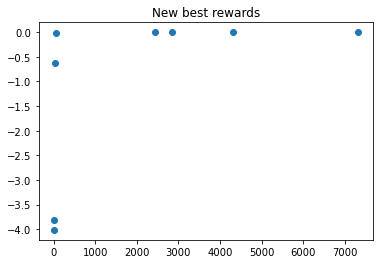

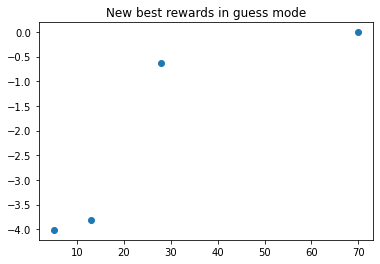

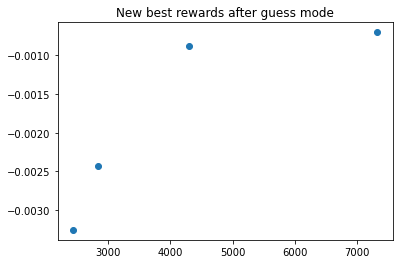

In [4]:
steps=[]
rew=[]
for el in env.improv_hist:
        steps.append(el[0])
        rew.append(el[1])
        
plt.scatter(steps,rew)
plt.title('New best rewards')
plt.show()

min_index=len(rew)
for i,step in enumerate(steps):
        if step>guess_steps:
                min_index=i
                break
                
plt.scatter(steps[:min_index],rew[:min_index])
plt.title('New best rewards in guess mode')
plt.show()
plt.scatter(steps[min_index:],rew[min_index:])
plt.title('New best rewards after guess mode')
plt.show()

Improvements in the later stages seem very sparse. 

In [5]:
print('Number of improvements:', len(rew))
print('Lowest error:', env.best_reward*(1/reward_scale))
print('Best state:', env.best_state)

Number of improvements: 8
Lowest error: -0.1400451974888415
Best state: [2.4718163  0.         0.20118096 6.35977888 3.51728958 0.
 3.19599533 0.         6.5        0.        ]


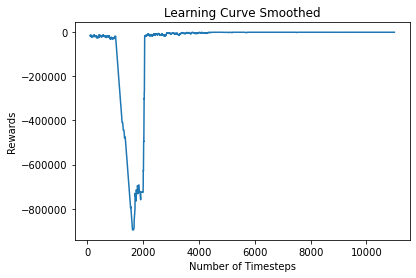

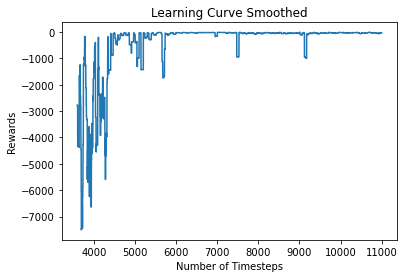

In [6]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, start=0, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = results_plotter.ts2xy(results_plotter.load_results(log_folder), 'timesteps')
    x=x[start:]
    y=y[start:]
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
    
plot_results(log_dir)
plot_results(log_dir, start=guess_steps) #Plot only results after guess mode

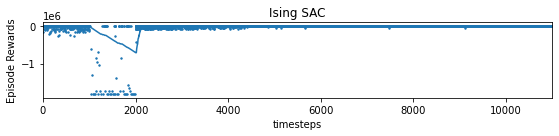

In [7]:
results_plotter.plot_results([log_dir], None, results_plotter.X_TIMESTEPS, "Ising SAC")
plt.show()